# About

Pneumonia is a very serious condition that has a chance of occuring in all individuals.

If not treated it can have very serious negative effects, including death.

Because of the likelyhood of dying from pneumonia, it is important to increase the odds of detecting the signs of pneumonia given the chest x-rays of a patient.

### Recall or Precision
In this instance we will focus on recall over precision, given the penalty for a false negative is quite likely the patient's death.

This quote accurately describes our use case.
<blockquote>
'In an imbalanced classification problem with two classes, recall is calculated as the number of true positives divided by the total number of true positives and false negatives. The result is a value between 0.0 for no recall and 1.0 for full or perfect recall. ... Recall = 90 / (90 + 10) Recall = 90 / 100.'</blockquote>

### Import the required libraries
This project depends heavily on the keras library as you can see

In [1]:
import pandas as pd
import numpy as np
from keras import models
from keras import layers
from keras import optimizers
import matplotlib.pyplot as plt
import tensorflow as tf
import os
from keras.utils.vis_utils import plot_model
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array

Using TensorFlow backend.


### Path to Data
Colab has a particular hierchy, let's make sure we are telling it the correct locations for our data


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
ls

drive/  sample_data/


In [6]:
!cp /content/drive/My\ Drive/pneumonia/data.zip /content

In [ ]:
!unzip data.zip

### Image Generator
Using the very useful ImageDataGenerator from keras, we can create a generator that will feed us images in a non-stop loop.

Additionally, we can tell it to augment the images it is spitting out, which we can use to decrease the overfitting that tends to happen on smaller datasets like this.

In [8]:
pneumonia_root = f'/content/'

train_path = pneumonia_root + 'data/train'
test_path = pneumonia_root + 'data/test'

In [36]:
train_datagen = ImageDataGenerator(rescale=1./255,
                               rotation_range=40,
                               width_shift_range=0.2, 
                               height_shift_range=0.2, 
                               shear_range=0.2, 
                               zoom_range=0.2, 
                               horizontal_flip=True, 
                               fill_mode='nearest')

train_gen = train_datagen.flow_from_directory(
    train_path,
    class_mode='binary',
    seed=42,
    target_size=(150, 150),
    batch_size=512
)
test_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
    test_path,
    class_mode='binary',
    seed=42,
    target_size=(150, 150),
    batch_size=512
)

train_img_sample, train_label_sample = next(train_gen)
test_img_sample, test_label_sample = next(test_gen)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


### Inspect Data
Let's examine an example of each possible outcome. Even though we will not be distinguishing between the differen types of pneumonia (there are not enough samples), it is still important to visually inspect the differences.

Notice the different versions of this same picture. Thanks to our generator we have never ending augmentations of the same xrays.

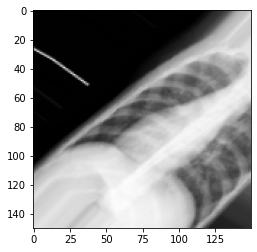

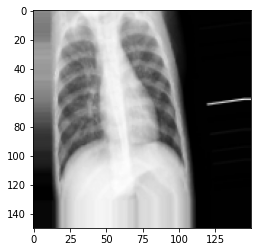

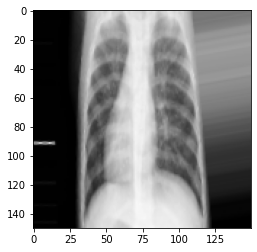

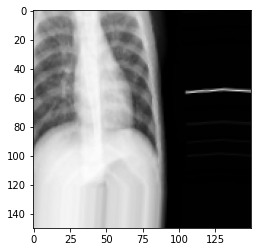

In [10]:
x = img_to_array(train_img_sample[0]) 
x = x.reshape((1,) + x.shape) 
i=0
for batch in train_datagen.flow(x, batch_size=1):
  plt.figure(i)
  imgplot = plt.imshow(array_to_img(batch[0])) 
  i += 1
  if i % 4 == 0:
    break 
  plt.show()

### Setup Model

In [30]:
def get_model():
  model = models.Sequential() 
  model.add(layers.Conv2D(32, (3, 3), activation='relu',
      input_shape=(150, 150, 3))) 
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu')) 
  model.add(layers.MaxPooling2D((2, 2))) 
  model.add(layers.Conv2D(128, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2))) 
  model.add(layers.Conv2D(128, (3, 3), activation='relu')) 
  model.add(layers.MaxPooling2D((2, 2))) 
  model.add(layers.Flatten()) 
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(512, activation='relu'))
  model.add(layers.Dense(1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', 
                optimizer='rmsprop',
                metrics=['acc'])
  return model

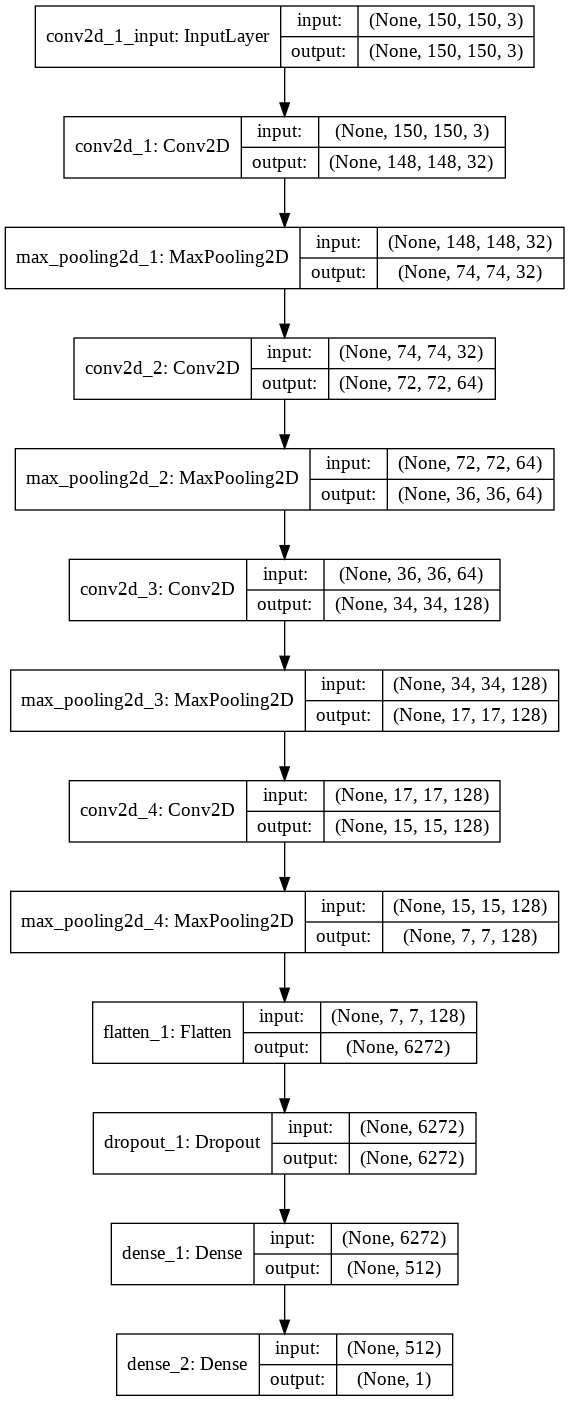

In [14]:
plot_model(get_model(), to_file='model_plot.png', show_shapes=True, show_layer_names=True)

### GPU Check

In [15]:
tf.test.gpu_device_name()

'/device:GPU:0'

# Evaluation
Here we evaluate and visualize the metrics for each of the models we fit.

In [16]:
def evaluate_model(model, history):
  for metric in history.history.keys():
      plt.plot(history.history[metric], label=metric)
  plt.legend()
  print(zip(['loss', 'accuracy'], model.evaluate(test_img_sample, 
                                                 test_label_sample)))

Logging
Here we create a function to keep track of the different models and their scores.

This is what we want our log to look like:

|date|model|description|loss|acc|macro recall|
|---|---|---|---|---|---|
|2020-06-15 14:17:16.246488|pneumonia_001.h5|initial model fit on original images|.6|.78|.5|

In [17]:
from datetime import datetime
import uuid
from sklearn.metrics import recall_score



def Log(model, description='', metrics=[], path='/models'):
    test_y_hat = model.predict_classes(test_img_sample)
    metrics = model.evaluate_generator(test_gen)
    recall = recall_score(test_label_sample, test_y_hat, average='macro')
    metrics += [recall]
    try:
      os.listdir(path)
    except:
      os.mkdir(path)
    date = datetime.now()
    model_fname = f"{uuid.uuid1()}.h5"
    model.save(path +'/'+ model_fname)
    description = description
    loss, acc, recall = metrics
    with open(path + '/models.log', 'a') as f:
        entry = f"{date}, {model_fname}, {description}, {loss}, {acc}, {recall}\n"
        f.write(entry)

## CPU: Default Params (Baseline)
Using default 32 batch size and no augmentations.

In [ ]:
# history = model.fit_generator(train_gen, epochs=20, validation_data=test_gen)

Epoch 1/20
163/163 [==============================] - 259s 2s/step - loss: 0.3984 - acc: 0.8244 - val_loss: 1.0587 - val_acc: 0.7099
Epoch 2/20
163/163 [==============================] - 257s 2s/step - loss: 0.1841 - acc: 0.9277 - val_loss: 1.0032 - val_acc: 0.7420
Epoch 3/20
163/163 [==============================] - 255s 2s/step - loss: 0.1425 - acc: 0.9402 - val_loss: 0.7790 - val_acc: 0.7484
Epoch 4/20
163/163 [==============================] - 255s 2s/step - loss: 0.1175 - acc: 0.9551 - val_loss: 0.8597 - val_acc: 0.7821
Epoch 5/20
163/163 [==============================] - 258s 2s/step - loss: 0.1038 - acc: 0.9609 - val_loss: 1.0662 - val_acc: 0.6939
Epoch 6/20
163/163 [==============================] - 253s 2s/step - loss: 0.0955 - acc: 0.9643 - val_loss: 1.0723 - val_acc: 0.7308
Epoch 7/20
163/163 [==============================] - 320s 2s/step - loss: 0.0871 - acc: 0.9670 - val_loss: 1.6554 - val_acc: 0.7724
Epoch 8/20
163/163 [==============================] - 274s 2s/step - 

### Analysis
We can see in the graph below that the training accuracy increases a lot in the first epoch, then barely changes for the rest.

The validation accuracy goes up and down, but never changes much from where it started.

This is from the small batch size, and the inability the learn new features with so little variety.

32/32 [==============================] - 0s 12ms/step


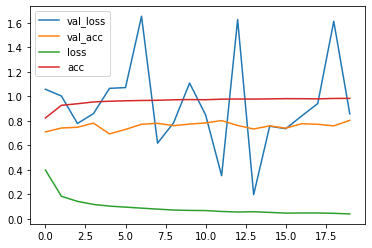

In [ ]:
# evaluate_model(model, history)

In [ ]:
# path = f"/content/drive/My Drive/models"
# Log(model, 'raw data fit on default batch size using CPU', path=path)

## GPU: Default Params
Right away we notice the huge difference in time per step. Instead of 2 seconds per step, were now at around 330ms, a fraction of the time it was taking for the CPU

In [ ]:
# history = model.fit_generator(train_gen, epochs=20, validation_data=test_gen)

Epoch 1/20
163/163 [==============================] - 60s 366ms/step - loss: 0.4195 - acc: 0.8142 - val_loss: 0.6933 - val_acc: 0.7740
Epoch 2/20
163/163 [==============================] - 53s 328ms/step - loss: 0.1900 - acc: 0.9262 - val_loss: 0.0488 - val_acc: 0.8125
Epoch 3/20
163/163 [==============================] - 53s 325ms/step - loss: 0.1367 - acc: 0.9500 - val_loss: 1.2299 - val_acc: 0.7612
Epoch 4/20
163/163 [==============================] - 53s 327ms/step - loss: 0.1157 - acc: 0.9572 - val_loss: 0.6039 - val_acc: 0.7580
Epoch 5/20
163/163 [==============================] - 54s 331ms/step - loss: 0.1062 - acc: 0.9595 - val_loss: 0.3126 - val_acc: 0.7724
Epoch 6/20
163/163 [==============================] - 53s 328ms/step - loss: 0.0950 - acc: 0.9649 - val_loss: 0.3060 - val_acc: 0.7564
Epoch 7/20
163/163 [==============================] - 54s 329ms/step - loss: 0.0856 - acc: 0.9699 - val_loss: 0.1715 - val_acc: 0.6795
Epoch 8/20
163/163 [==============================] - 5

### Analysis


32/32 [==============================] - 0s 549us/step


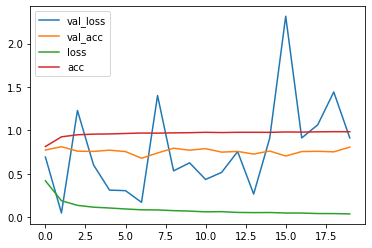

In [ ]:
# evaluate_model(model, history)

In [ ]:
# path = f"/content/drive/My Drive/models"
# Log(model, 'raw data fit on default batch size using GPU', path=path)

## GPU: Larger Batches for more efficient GPU Processing
Now that we are working with GPU power, we need to make sure we are feeding it large enough chunks, in multiples of 8 (our GPU has 8 cores). 

According to the book "Deep Learning with Python", we should feed in the biggest chunks we can withouth running out of memory. 

Lets increase the batch size until we run into memory problems and then pick a number slightly less than that.

Notice our amount of steps decreased from 163 to 11, though the time per epoch is about the same at around 55 seconds.

In [ ]:
# history = model.fit_generator(train_gen, epochs=20, validation_data=test_gen)

Epoch 1/20
11/11 [==============================] - 56s 5s/step - loss: 0.0292 - acc: 0.9900 - val_loss: 1.2437 - val_acc: 0.7821
Epoch 2/20
11/11 [==============================] - 52s 5s/step - loss: 0.0305 - acc: 0.9904 - val_loss: 1.3247 - val_acc: 0.7756
Epoch 3/20
11/11 [==============================] - 53s 5s/step - loss: 0.0267 - acc: 0.9902 - val_loss: 0.8032 - val_acc: 0.7869
Epoch 4/20
11/11 [==============================] - 52s 5s/step - loss: 0.0264 - acc: 0.9904 - val_loss: 1.8362 - val_acc: 0.6907
Epoch 5/20
11/11 [==============================] - 53s 5s/step - loss: 0.0295 - acc: 0.9891 - val_loss: 0.9605 - val_acc: 0.7885
Epoch 6/20
11/11 [==============================] - 53s 5s/step - loss: 0.0238 - acc: 0.9919 - val_loss: 1.3873 - val_acc: 0.7516
Epoch 7/20
11/11 [==============================] - 53s 5s/step - loss: 0.0249 - acc: 0.9925 - val_loss: 1.3673 - val_acc: 0.7516
Epoch 8/20
11/11 [==============================] - 52s 5s/step - loss: 0.0295 - acc: 0.98

### Analysis
Definitely some extreme overfitting. The accuracy is almost 100% the entire time, but the validation score is not  changing much.

512/512 [==============================] - 0s 472us/step


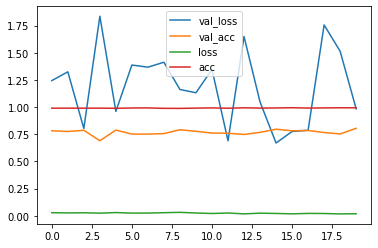

In [ ]:
# evaluate_model(model, history)

In [ ]:
# path = f"/content/drive/My Drive/models"
# Log(model, 'raw data fit on large (512) size using GPU', path=path)

## GPU: Adding Augmentation for Overfitting



In [ ]:
history = model.fit_generator(train_gen, epochs=20, validation_data=test_gen)

Epoch 1/20
11/11 [==============================] - 92s 8s/step - loss: 0.5946 - acc: 0.7366 - val_loss: 0.7125 - val_acc: 0.6250
Epoch 2/20
11/11 [==============================] - 87s 8s/step - loss: 0.5815 - acc: 0.7429 - val_loss: 0.7789 - val_acc: 0.6250
Epoch 3/20
11/11 [==============================] - 87s 8s/step - loss: 0.5588 - acc: 0.7441 - val_loss: 0.6026 - val_acc: 0.6250
Epoch 4/20
11/11 [==============================] - 88s 8s/step - loss: 0.5338 - acc: 0.7496 - val_loss: 0.6109 - val_acc: 0.7420
Epoch 5/20
11/11 [==============================] - 87s 8s/step - loss: 0.5490 - acc: 0.7423 - val_loss: 0.5714 - val_acc: 0.6362
Epoch 6/20
11/11 [==============================] - 86s 8s/step - loss: 0.5017 - acc: 0.7600 - val_loss: 0.5239 - val_acc: 0.6410
Epoch 7/20
11/11 [==============================] - 87s 8s/step - loss: 0.4851 - acc: 0.7705 - val_loss: 0.5467 - val_acc: 0.7660
Epoch 8/20
11/11 [==============================] - 87s 8s/step - loss: 0.4775 - acc: 0.78

### Analysis
The scores for this version are all over the place. Even though there is constant upward trend. 

Could continue running this one until the accuracy stops improving.

512/512 [==============================] - 1s 1ms/step


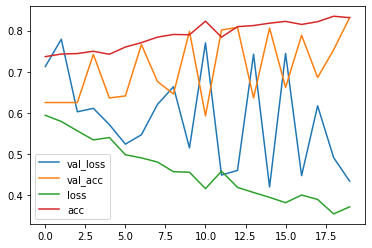

In [ ]:
evaluate_model(model, history)

In [ ]:
path = f"/content/drive/My Drive/models"
Log(model, 'augmented data fit on large (512) size using GPU', path=path)

## GPU: Adding Dropout Layer for Overfitting

The overfitting is similar still, with the validation loss and accuracy bouncing back every other epoch.

512/512 [==============================] - 0s 725us/step


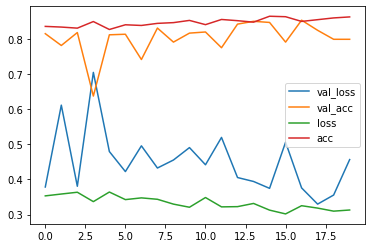

In [ ]:
evaluate_model(model, history)

In [ ]:
path = f"/content/drive/My Drive/models"
Log(model, 'augmented data 512 batch size using dropout on GPU', path=path)

## GPU: 100 steps per epoch

In [ ]:
history = get_model().fit_generator(train_gen, 
                              steps_per_epoch=100,
                              epochs=20,                              
                              validation_data=test_gen)

Epoch 1/20
100/100 [==============================] - 781s 8s/step - loss: 0.5395 - acc: 0.7571 - val_loss: 0.6513 - val_acc: 0.6779
Epoch 2/20
100/100 [==============================] - 772s 8s/step - loss: 0.4497 - acc: 0.7990 - val_loss: 0.4625 - val_acc: 0.7692
Epoch 3/20
100/100 [==============================] - 772s 8s/step - loss: 0.3847 - acc: 0.8259 - val_loss: 1.1845 - val_acc: 0.6266
Epoch 4/20
100/100 [==============================] - 744s 7s/step - loss: 0.3454 - acc: 0.8486 - val_loss: 0.3236 - val_acc: 0.8141
Epoch 5/20
100/100 [==============================] - 795s 8s/step - loss: 0.3222 - acc: 0.8559 - val_loss: 0.8373 - val_acc: 0.6442
Epoch 6/20
100/100 [==============================] - 799s 8s/step - loss: 0.2994 - acc: 0.8711 - val_loss: 0.3725 - val_acc: 0.8526
Epoch 7/20
100/100 [==============================] - 791s 8s/step - loss: 0.2882 - acc: 0.8763 - val_loss: 0.3513 - val_acc: 0.8510
Epoch 8/20
100/100 [==============================] - 797s 8s/step - 

### Analyze
This model has a better chance to begin to converge on a maximum accuracy, and we even see after epoch 13 the validation set starts to decrease both in loss and accuracy

512/512 [==============================] - 0s 917us/step


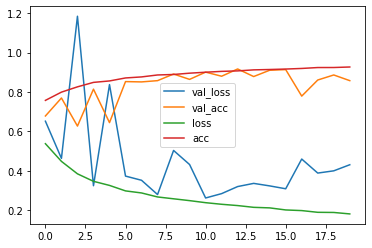

In [ ]:
evaluate_model(model, history)

In [ ]:
path = f"/content/drive/My Drive/models"
Log(model, 'augmented data 512 batch size using dropout on GPU', path=path)

## Running Until Epoch 15 (when previous model began to overfit)

In [ ]:
model = get_model()
history = model.fit_generator(train_gen, 
                              steps_per_epoch=100,
                              epochs=15,                              
                              validation_data=test_gen)

Epoch 1/15
100/100 [==============================] - 775s 8s/step - loss: 0.5391 - acc: 0.7518 - val_loss: 0.6436 - val_acc: 0.6282
Epoch 2/15
100/100 [==============================] - 784s 8s/step - loss: 0.4456 - acc: 0.7987 - val_loss: 0.3866 - val_acc: 0.8189
Epoch 3/15
100/100 [==============================] - 790s 8s/step - loss: 0.3813 - acc: 0.8259 - val_loss: 0.4235 - val_acc: 0.8141
Epoch 4/15
100/100 [==============================] - 786s 8s/step - loss: 0.3453 - acc: 0.8440 - val_loss: 0.3480 - val_acc: 0.8542
Epoch 5/15
100/100 [==============================] - 784s 8s/step - loss: 0.3249 - acc: 0.8579 - val_loss: 0.4618 - val_acc: 0.8558
Epoch 6/15
100/100 [==============================] - 777s 8s/step - loss: 0.3019 - acc: 0.8695 - val_loss: 0.3146 - val_acc: 0.8702
Epoch 7/15
100/100 [==============================] - 794s 8s/step - loss: 0.2838 - acc: 0.8747 - val_loss: 0.6116 - val_acc: 0.7404
Epoch 8/15
100/100 [==============================] - 797s 8s/step - 

### Analyze
Here we tried to stop at the most ideal epoch of the last models history. Although we stopped the model before the validation scores began to steadily decline, we don't get the accuracy up very high.

512/512 [==============================] - 1s 1ms/step


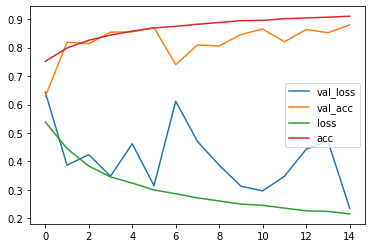

In [ ]:
evaluate_model(model, history)

In [ ]:
path = f"/content/drive/My Drive/models"
Log(model, 'augmented data 512 batch size using dropout on GPU 100 steps 15 epochs', path=path)

# Adding Callbacks
It is very valuable to be able to execute functions after each epoch. 

Keras offers this with callbacks we can pass in that will do things like save the model weights, write scores to logs, and even stop early if the score ceases to increase.

In [19]:
from keras import callbacks
my_callbacks = [
    callbacks.EarlyStopping(patience=2),
    callbacks.ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.h5'),
    callbacks.TensorBoard(log_dir='./logs'),
]

## Running with double the ram and image batch (1024) and passing in callback for saving best checkpoint


In [ ]:
model = get_model()
history = model.fit_generator(train_gen, 
                              steps_per_epoch=100,
                              epochs=20,                              
                              validation_data=test_gen,
                              callbacks=my_callbacks
                              )


Epoch 1/20
100/100 [==============================] - 1331s 13s/step - loss: 0.5329 - acc: 0.7557 - val_loss: 0.6726 - val_acc: 0.5801
Epoch 2/20
100/100 [==============================] - 1328s 13s/step - loss: 0.4451 - acc: 0.7973 - val_loss: 0.4433 - val_acc: 0.7997
Epoch 3/20
100/100 [==============================] - 1341s 13s/step - loss: 0.3845 - acc: 0.8272 - val_loss: 0.4218 - val_acc: 0.7965
Epoch 4/20
100/100 [==============================] - 1327s 13s/step - loss: 0.3451 - acc: 0.8445 - val_loss: 0.4079 - val_acc: 0.8013
Epoch 5/20
100/100 [==============================] - 1297s 13s/step - loss: 0.3172 - acc: 0.8621 - val_loss: 0.4083 - val_acc: 0.8269
Epoch 6/20
100/100 [==============================] - 1246s 12s/step - loss: 0.2971 - acc: 0.8717 - val_loss: 0.5761 - val_acc: 0.7292


### Analysis
This seems similar to the idea of taking very large steps. This is because we are sending in 1024 images to the model at each step. 

Can definately lead to overfitting, and we could overstep the global min.

624/624 [==============================] - 0s 449us/step


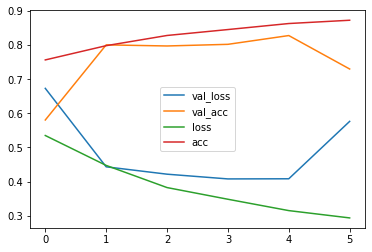

In [ ]:
evaluate_model(model, history)

In [ ]:
path = f"/content/drive/My Drive/models"
Log(model, '1024 batchs with early stopping callbacks', path=path)

## GPU: 512 batch size with more steps and epochs

In [ ]:
history = get_model().fit_generator(train_gen, 
                              steps_per_epoch=100,
                              epochs=30,                              
                              validation_data=test_gen,
                              callbacks=my_callbacks)

Epoch 1/30
100/100 [==============================] - 715s 7s/step - loss: 0.6440 - acc: 0.7428 - val_loss: 1.0910 - val_acc: 0.6250
Epoch 2/30
100/100 [==============================] - 690s 7s/step - loss: 0.4759 - acc: 0.7740 - val_loss: 0.5492 - val_acc: 0.6907
Epoch 3/30
100/100 [==============================] - 693s 7s/step - loss: 0.4348 - acc: 0.8047 - val_loss: 0.4451 - val_acc: 0.7917
Epoch 4/30
100/100 [==============================] - 680s 7s/step - loss: 0.3486 - acc: 0.8466 - val_loss: 0.3150 - val_acc: 0.8590
Epoch 5/30
100/100 [==============================] - 690s 7s/step - loss: 0.2876 - acc: 0.8779 - val_loss: 0.3196 - val_acc: 0.8750
Epoch 6/30
100/100 [==============================] - 688s 7s/step - loss: 0.2494 - acc: 0.8936 - val_loss: 0.3525 - val_acc: 0.8413


### Analysis
This shows a similar result as last model, except the beginning shows more variation.

The ending result is still the same though, with clear signs of the validation set declining both in accuracy and loss scores.

In [ ]:
model.load_weights('model.05-0.32.h5')

512/512 [==============================] - 0s 319us/step


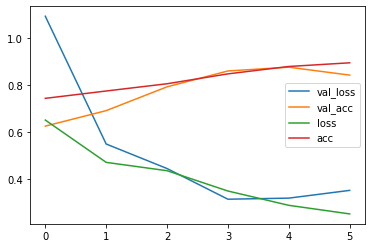

In [ ]:
evaluate_model(model, history)

In [ ]:
path = f"/content/drive/My Drive/models"
Log(model, '1024 batchs with early stopping callbacks', path=path)

## SMALL batch sizes, 256, with lots of steps

In [ ]:
history = get_model().fit_generator(train_gen, 
                              steps_per_epoch=200,
                              epochs=30,                              
                              validation_data=test_gen,
                              callbacks=my_callbacks)

Epoch 1/30
200/200 [==============================] - 715s 4s/step - loss: 0.5940 - acc: 0.7588 - val_loss: 0.6671 - val_acc: 0.6955
Epoch 2/30
200/200 [==============================] - 712s 4s/step - loss: 0.3938 - acc: 0.8204 - val_loss: 0.5101 - val_acc: 0.7692
Epoch 3/30
200/200 [==============================] - 713s 4s/step - loss: 0.3010 - acc: 0.8751 - val_loss: 0.3436 - val_acc: 0.7837
Epoch 4/30
200/200 [==============================] - 716s 4s/step - loss: 0.2423 - acc: 0.9012 - val_loss: 0.3744 - val_acc: 0.8173
Epoch 5/30
200/200 [==============================] - 716s 4s/step - loss: 0.1988 - acc: 0.9185 - val_loss: 0.2513 - val_acc: 0.9054
Epoch 6/30
200/200 [==============================] - 720s 4s/step - loss: 0.1728 - acc: 0.9308 - val_loss: 0.2612 - val_acc: 0.8974
Epoch 7/30
200/200 [==============================] - 718s 4s/step - loss: 0.1548 - acc: 0.9383 - val_loss: 0.3743 - val_acc: 0.8734


### Analysis
This starts to look a little bit better, with the model able to make more adjustments with the smaller batch size.

The end still results in the same overfitting at about the same values.

Our highest score so far is from taking one of the checkpoints from this version.

256/256 [==============================] - 0s 317us/step


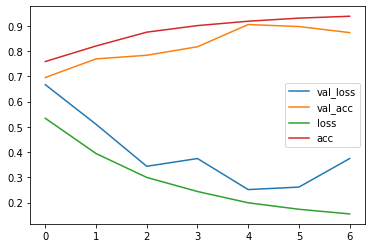

In [ ]:
model.load_weights('model.05-0.25.h5')
evaluate_model(model, history)

In [ ]:
path = f"/content/drive/My Drive/models"
Log(model, '256 batchs with early stopping callbacks and 200 epochs', path=path)

# Adding pretrained layers
We will use a model and pretrained weights now as our base convolutional layers, and we will put some dense layers and our final sigmoid activated layer on the top.

In [18]:
from keras.applications import VGG16

def get_pretrained_model():
  conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))
  conv_base.trainable = False
  model = models.Sequential() 
  model.add(conv_base)
  model.add(layers.Flatten()) 
  model.add(layers.Dense(256, activation='relu')) 
  model.add(layers.Dense(1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', 
              optimizer='rmsprop',
              metrics=['acc'])
  return model

## Imagenet weights with VGG16 model

In [20]:
model_pretrained = get_pretrained_model()
history = model_pretrained.fit_generator(train_gen, 
                              steps_per_epoch=200,
                              epochs=30,                              
                              validation_data=test_gen,
                              callbacks=my_callbacks)


58892288/58889256 [==============================] - 5s 0us/step
Epoch 1/30
200/200 [==============================] - 697s 3s/step - loss: 0.3419 - acc: 0.8641 - val_loss: 0.2376 - val_acc: 0.8942
Epoch 2/30
200/200 [==============================] - 687s 3s/step - loss: 0.1943 - acc: 0.9217 - val_loss: 0.3804 - val_acc: 0.8958
Epoch 3/30
200/200 [==============================] - 652s 3s/step - loss: 0.1680 - acc: 0.9346 - val_loss: 0.2625 - val_acc: 0.9151


256/256 [==============================] - 1s 3ms/step


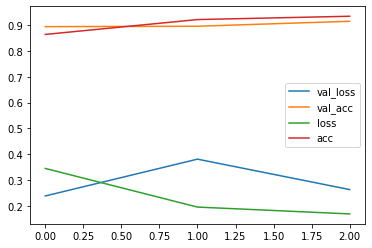

In [21]:
evaluate_model(model_pretrained, history)

In [23]:
path = f"/content/drive/My Drive/models"
Log(model_pretrained, 'using imagenet and 200 steps', path=path)

## Imagenet with less steps per epoch

In [25]:
model_pretrained = get_pretrained_model()
history = model_pretrained.fit_generator(train_gen, 
                              steps_per_epoch=20,
                              epochs=30,                              
                              validation_data=test_gen,
                              callbacks=my_callbacks)

Epoch 1/30
20/20 [==============================] - 66s 3s/step - loss: 0.8469 - acc: 0.7248 - val_loss: 0.6445 - val_acc: 0.6474
Epoch 2/30
20/20 [==============================] - 65s 3s/step - loss: 0.3218 - acc: 0.8429 - val_loss: 0.5119 - val_acc: 0.7356
Epoch 3/30
20/20 [==============================] - 65s 3s/step - loss: 0.3106 - acc: 0.8560 - val_loss: 0.4957 - val_acc: 0.8221
Epoch 4/30
20/20 [==============================] - 64s 3s/step - loss: 0.2696 - acc: 0.8792 - val_loss: 0.3073 - val_acc: 0.8510
Epoch 5/30
20/20 [==============================] - 66s 3s/step - loss: 0.2496 - acc: 0.8838 - val_loss: 0.5324 - val_acc: 0.7949
Epoch 6/30
20/20 [==============================] - 61s 3s/step - loss: 0.2589 - acc: 0.8852 - val_loss: 0.2693 - val_acc: 0.8894
Epoch 7/30
20/20 [==============================] - 66s 3s/step - loss: 0.2242 - acc: 0.9062 - val_loss: 0.2947 - val_acc: 0.8942
Epoch 8/30
20/20 [==============================] - 62s 3s/step - loss: 0.2435 - acc: 0.89

256/256 [==============================] - 0s 1ms/step


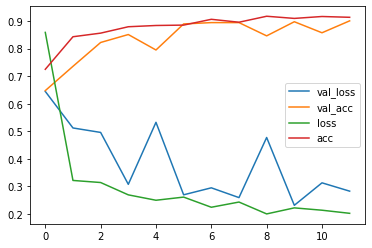

In [26]:
evaluate_model(model_pretrained, history)

In [27]:
path = f"/content/drive/My Drive/models"
Log(model_pretrained, 'using imagenet and 20 steps', path=path)

## InceptionResNetV2

In [34]:
from keras.applications import InceptionResNetV2
def get_inception_model():
  inception_model = InceptionResNetV2(weights='imagenet',
                    include_top=False,
                    input_shape=(150, 150, 3))

  inception_model.trainable = False
  model = models.Sequential() 
  model.add(inception_model)
  model.add(layers.Flatten()) 
  model.add(layers.Dense(256, activation='relu')) 
  model.add(layers.Dropout(.5))
  model.add(layers.Dense(1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', 
              optimizer='rmsprop',
              metrics=['acc'])
  return model

In [35]:
model = get_inception_model()

219062272/219055592 [==============================] - 14s 0us/step


In [37]:
history = model.fit_generator(train_gen, 
                              steps_per_epoch=20,
                              epochs=30,                              
                              validation_data=test_gen,
                              callbacks=my_callbacks)

Epoch 1/30
20/20 [==============================] - 132s 7s/step - loss: 1.8552 - acc: 0.7083 - val_loss: 0.8174 - val_acc: 0.4022
Epoch 2/30
20/20 [==============================] - 119s 6s/step - loss: 0.5062 - acc: 0.7621 - val_loss: 1.1779 - val_acc: 0.4119
Epoch 3/30
20/20 [==============================] - 119s 6s/step - loss: 0.4590 - acc: 0.7784 - val_loss: 2.3184 - val_acc: 0.3846


## Log:
Loaded logs and print out Data Frame

In [ ]:
model.load_weights('model.04-0.41.h5')

In [28]:
pd.read_csv(f'/content/drive/My Drive/models/models.log', names=['datetime', 'model_filename', 'description', 'loss', 'accuracy', 'macro_recall'])

,datetime,model_filename,description,loss,accuracy,macro_recall
0,2020-06-16 23:44:17.556418,/4af7a64a-b02b-11ea-9039-0242ac1c0002.h5,raw data fit on default batch size using CPU,1.219382,0.804487,0.857143
1,2020-06-17 00:35:52.800130,7fd900dc-b032-11ea-a3a7-0242ac1c0002.h5,raw data fit on default batch size using CPU,0.913647,0.807692,0.793651
2,2020-06-17 00:37:07.798693,ac8cdfb8-b032-11ea-a3a7-0242ac1c0002.h5,raw data fit on default batch size using GPU,0.913647,0.807692,0.793651
3,2020-06-17 00:58:33.778595,ab0dd734-b035-11ea-a3a7-0242ac1c0002.h5,raw data fit on large (512) size using GPU,0.998140,0.804487,0.759725
4,2020-06-17 02:57:25.545171,45ee406c-b046-11ea-894f-0242ac1c0002.h5,augmented data fit on large (512) size using GPU,0.348728,0.830128,0.822511
5,2020-06-17 03:32:14.814252,233840e0-b04b-11ea-894f-0242ac1c0002.h5,augmented data 512 batch size using dropout o...,0.377758,0.799679,0.732487
6,2020-06-17 08:03:06.952363,fa3fb224-b070-11ea-894f-0242ac1c0002.h5,augmented data 512 batch size using dropout o...,0.565851,0.766026,0.686924
7,2020-06-17 19:06:38.847786,ac002a00-b0cd-11ea-9be7-0242ac1c0002.h5,augmented data 512 batch size using dropout o...,0.382027,0.879808,0.849790
8,2020-06-17 21:32:15.266196,0350aaa0-b0e2-11ea-b53f-0242ac1c0002.h5,1024 batchs with early stopping callbacks,0.576110,0.729167,0.638889
9,2020-06-17 21:35:14.583849,6e2e30b8-b0e2-11ea-b53f-0242ac1c0002.h5,1024 batchs with early stopping callbacks,0.408343,0.826923,0.771795
